<a href="https://colab.research.google.com/github/Huynhngocthanh/DoAn_2022/blob/main/NThanh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

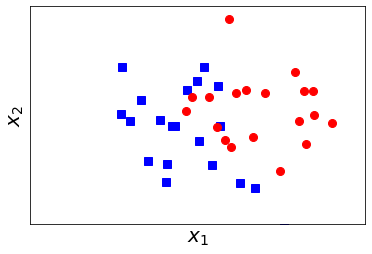

In [16]:
# Để hỗ trợ cả python 2 và python 3
from __future__ import division, print_function, unicode_literals
# list of points 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.backends.backend_pdf import PdfPages
np.random.seed(22)

means = [[2, 2], [4, 2]]
cov = [[.7, 0], [0, .7]]
N = 20
X0 = np.random.multivariate_normal(means[0], cov, N) # each row is a data point 
X1 = np.random.multivariate_normal(means[1], cov, N)

with PdfPages('./data.pdf') as pdf:
    plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = 1)
    plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = 1)
    plt.axis('equal')
    plt.ylim(0, 4)
    plt.xlim(0, 5)

    # hide tikcs 
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([])
    cur_axes.axes.get_yaxis().set_ticks([])

    plt.xlabel('$x_1$', fontsize = 20)
    plt.ylabel('$x_2$', fontsize = 20)
    pdf.savefig()
    # plt.savefig('logistic_2d.png', bbox_inches='tight', dpi = 300)
    plt.show()

5.1.1. Khai báo thư viện và tạo dữ liệu giả

In [17]:
#tạo dữ liệu
#danh sách các điểm
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(21)
from matplotlib.backends.backend_pdf import PdfPages

means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 10
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
#X = np.concatenate((X0.T, X1.T), axis = 1)
#y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

In [18]:
X = np.vstack((X0, X1)) 
y = np.vstack((np.ones((N,1 )), -np.ones((N,1 )))).reshape((2*N,))

5.1.2. Giải bài toán bằng thư viện sklearn Ta chọn C = 100 trong thí nghiệm này

In [19]:
from sklearn.svm import SVC
C = 100 
clf = SVC(kernel = 'linear', C = C)
y=y.reshape(-1,1) 
clf.fit(X, y) 


w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]
print(w_sklearn.T, b_sklearn)

[[-5.54202362  2.4156074 ]] 9.132415590204586


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5.1.3. Tìm nghiệm bằng giải bài toán đối ngẫu Tương tự như việc giải bài toán Hard Margin SVM, chỉ khác rằng ta có thêm ràng buộc về chặn trên của các nhân thử Lagrange

In [20]:
from cvxopt import matrix, solvers
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V))

p = matrix(-np.ones((2*N, 1)))
# build A, b, G, h 
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N))) 
b = matrix(np.zeros((1, 1))) 
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[1.26997770e-08 7.29907090e-09 6.75263620e+00 1.20067067e-08
  8.83482181e-09 1.00135373e-08 9.49241066e-09 1.10095260e-08
  1.09448265e-08 1.15277180e+01 3.06483278e-09 2.92217775e-09
  3.52341246e-09 5.49363383e-09 4.48478627e-09 7.55953464e-09
  2.73325320e-09 5.71296652e-09 5.02756847e-09 1.82803543e+01]]


Trong các thành phần của lambda tìm được, có rất nhiều thành phần nhỏ tới 1e-6 hay 1e-7. Đây chính là các lambda_i = 0. Có rất nhiều phần tử xấp xỉ 9.99e+01, đây chính là các lambda_i bằng với C = 100, tương ứng với các support vectors không nằm trên margins, các sai số nhỏ xảy ra do tính toán. Các giá trị còn lại nằm giữa 0 và 100 là các giá trị tương ứng với các điểm nằm chính xác trên hai margins.

Tiếp theo, ta cần tính w và b theo công thức ( 15 ) và ( 16 ) . Trước đó ta cần tìm tập hợp các điểm support và những điểm nằm trên margins

In [21]:
S = np.where(l > 1e-5)[0] # support set 
S2 = np.where(l < .999*C)[0] 

M = [val for val in S if val in S2] # intersection of two lists

XT = X.T # we need each column to be one data point in this alg
VS = V[:, S]
lS = l[S]
yM = y[M]
XM = XT[:, M]

w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM))
print(w_dual.T, b_dual)

[[-5.54276837  2.41628387]] 9.13290685085968


5.1.4. Tìm nghiệm bằng giải bài toán không ràng buộc Trong phương pháp này, chúng ta cần tính gradient của hàm mất mát. Như thường lệ, chúng ta cần kiểm chứng này bằng cách so sánh với numerical gradient.

Chú ý rằng trong phương pháp này, ta cần dùng tham số lam = 1/C

In [22]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data 

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C

def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + \
        .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias 

def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1] # no weight decay on bias
    return g
    
eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps 
        wm[i] -= eps 
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g 

w0 = np.random.randn(X0_bar.shape[0], 1) 
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient different: %f' %diff)

Gradient different: 0.000000


Vì sự khác nhau giữa hai cách tính gradient là bằng 0, ta có thể yên tâm rằng gradient tính được là chính xác.

Sau khi chắc chắn rằng gradient tìm được đã chính xác, ta có thể bắt đầu làm Gradient Descent

In [23]:
def grad_descent(w0, eta):
    w = w0
    it = 0 
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break 
    return w 
w0 = np.random.randn(X0_bar.shape[0], 1) 
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

iter 1 cost: 47.818294
iter 10001 cost: 1.306777
iter 20001 cost: 0.979035
iter 30001 cost: 0.670496
iter 40001 cost: 0.389639
iter 50001 cost: 0.183199
iter 60001 cost: 0.183199
iter 70001 cost: 0.183198
iter 80001 cost: 0.183198
iter 90001 cost: 0.183197
[[-5.54894385  2.41853936]] [9.14489666]
